In [5]:
# Chapter1

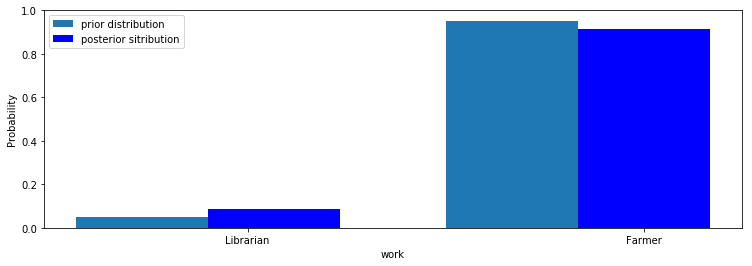

In [60]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
figsize(12.5, 4)

prior = [
    1/21.,
    20/21.
]

posterior = [
    0.087,
    1 - 0.087
]

plt.bar([0, .7], prior, width=0.25, label="prior distribution", lw="3")
plt.bar([0 + 0.25, .7 + 0.25], posterior, width=0.25, label="posterior sitribution", lw="3", color='blue')
plt.xticks([0.20, 0.95], ['Librarian', 'Farmer'])
plt.xlabel('work')
plt.ylabel('Probability')

plt.legend(loc="upper left")

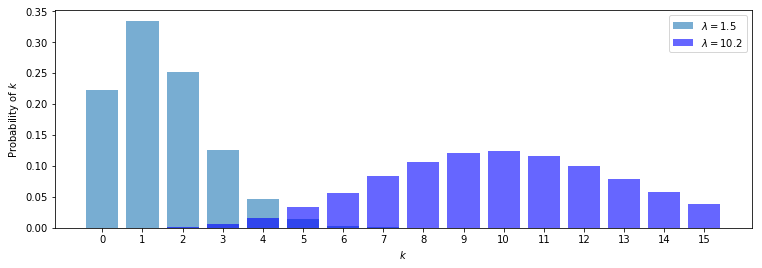

In [61]:
import scipy.stats as stats
figsize(12.5, 4)
poi = stats.poisson
lambda_ = [
    1.5,
    10.25
]
a = np.arange(16)
plt.bar(a, poi.pmf(a, lambda_[0]), label="$\lambda = %.1f$" % lambda_[0], alpha=0.6)
plt.bar(a, poi.pmf(a, lambda_[1]), label="$\lambda = %.1f$" % lambda_[1], color='blue', alpha=0.6)

plt.xticks(a)
plt.legend()

plt.ylabel("Probability of $k$")
plt.xlabel("$k$")

In [62]:
a = np.linspace(0, 4, 100)
print(a)

[ 0.          0.04040404  0.08080808  0.12121212  0.16161616  0.2020202
  0.24242424  0.28282828  0.32323232  0.36363636  0.4040404   0.44444444
  0.48484848  0.52525253  0.56565657  0.60606061  0.64646465  0.68686869
  0.72727273  0.76767677  0.80808081  0.84848485  0.88888889  0.92929293
  0.96969697  1.01010101  1.05050505  1.09090909  1.13131313  1.17171717
  1.21212121  1.25252525  1.29292929  1.33333333  1.37373737  1.41414141
  1.45454545  1.49494949  1.53535354  1.57575758  1.61616162  1.65656566
  1.6969697   1.73737374  1.77777778  1.81818182  1.85858586  1.8989899
  1.93939394  1.97979798  2.02020202  2.06060606  2.1010101   2.14141414
  2.18181818  2.22222222  2.26262626  2.3030303   2.34343434  2.38383838
  2.42424242  2.46464646  2.50505051  2.54545455  2.58585859  2.62626263
  2.66666667  2.70707071  2.74747475  2.78787879  2.82828283  2.86868687
  2.90909091  2.94949495  2.98989899  3.03030303  3.07070707  3.11111111
  3.15151515  3.19191919  3.23232323  3.27272727  3.3

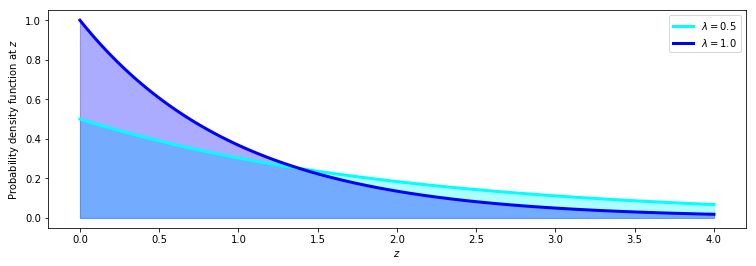

In [63]:
expo = stats.expon
lambda_ = [0.5, 1]
color_ = ['cyan', 'blue']

for l, c in zip(lambda_, color_):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3, label="$\lambda = %.1f$" % l, color=c)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)
plt.legend()
plt.xlabel("$z$")
plt.ylabel("Probability density function at $z$")

(0, 74)

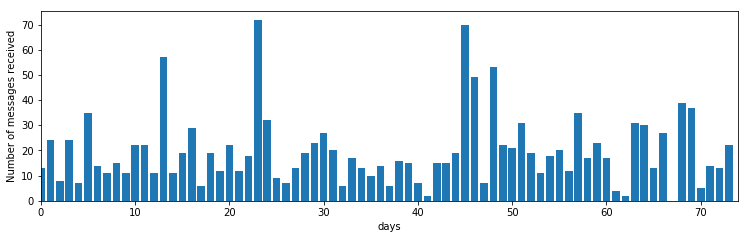

In [64]:
from os import makedirs
makedirs("data", exist_ok=True)
from urllib.request import urlretrieve
urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

figsize(12.5, 3.5)
count_data=np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data)

plt.xlabel("days")
plt.ylabel("Number of messages received")

plt.xlim(0, n_count_data)

In [65]:
import pymc as pm
alpha = 1.0 / count_data.mean()
print("1/mean: %f" % alpha)

1/mean: 0.050650


In [68]:
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

print("Random output: ", tau.random(), tau.random(), tau.random())

Random output:  70 62 39


In [71]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

# sampling
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)


 [-----------------100%-----------------] 40000 of 40000 complete in 7.8 sec

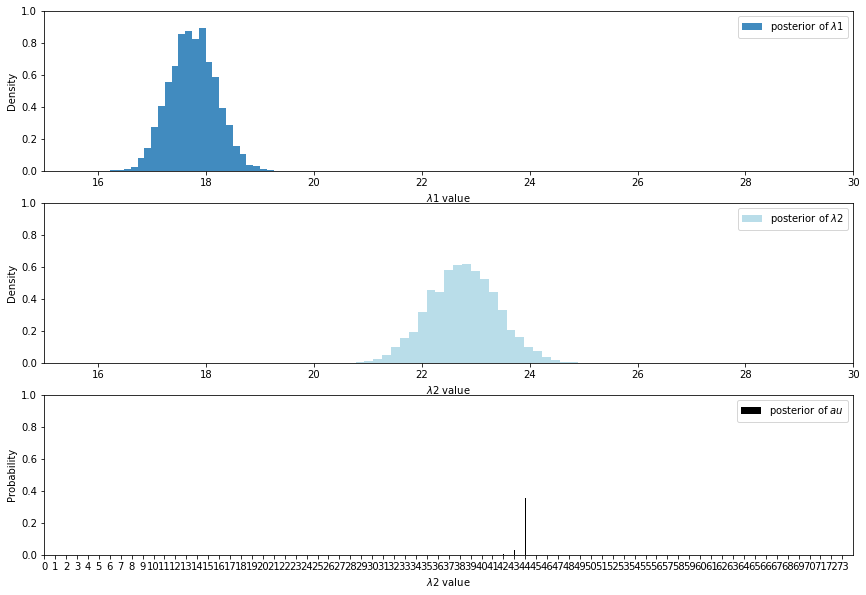

In [96]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

figsize(14.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, normed=True, label='posterior of $\lambda1$')
plt.xlim([15, 30])
plt.xlabel('$\lambda1$ value')
plt.ylabel('Density')
plt.legend()

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, normed=True, color='lightblue', label='posterior of $\lambda2$')
plt.xlim([15, 30])
plt.xlabel('$\lambda2$ value')
plt.ylabel('Density')
plt.legend()

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, histtype='stepfilled', bins=n_count_data, weights=w, alpha=1.0, rwidth=2.0, color='black', label='posterior of $\tau$')
plt.xticks(np.arange(n_count_data))
plt.xlim([0, n_count_data])
plt.ylim([0., 1.0])
plt.xlabel('$\lambda2$ value')
plt.ylabel('Probability')
plt.legend()

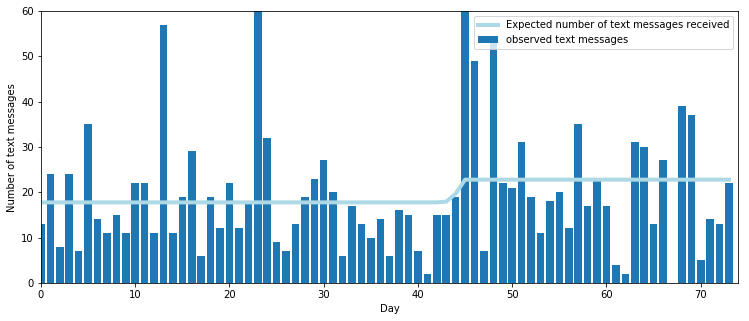

In [103]:
figsize(12.5, 5)

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)

# calc expectation
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N
    
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, label="Expected number of text messages received", color='lightblue')

plt.xlim(0, n_count_data)
plt.ylim(0, 60)
plt.xlabel('Day')
plt.ylabel('Number of text messages')

plt.bar(np.arange(n_count_data), count_data, label="observed text messages")

plt.legend()

In [104]:
l1m = lambda_1_samples.mean()
l2m = lambda_2_samples.mean()

print("l1m: %f, l2m: %f" % (l1m, l2m))

l1m: 17.751466, l2m: 22.768398


In [108]:
grad = ((lambda_2_samples - lambda_1_samples) / lambda_1_samples)
print("grad: %s, mean: %f" % (grad, grad.mean()))

grad: [ 0.22791406  0.22791406  0.22791406 ...,  0.31795839  0.31795839
  0.31795839], mean: 0.283395


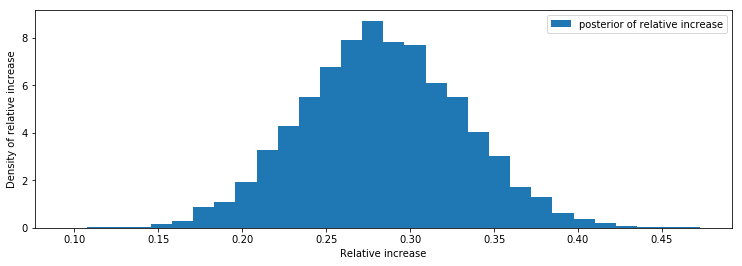

In [111]:
figsize(12.5, 4)
plt.hist(grad, histtype='stepfilled', bins=30, normed=True, label='posterior of relative increase')

plt.xlabel("Relative increase")
plt.ylabel("Density of relative increase")

plt.legend()

In [114]:
ix = tau_samples < 45
print(ix)

[False  True  True ...,  True  True  True]


In [115]:
lambda_1_samples[ix].mean()

17.736716641234114